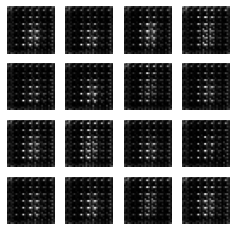

Time for epoch 1 is 38.51249361038208 sec


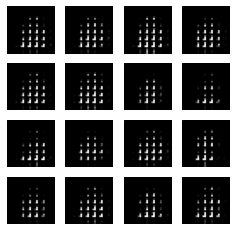

Time for epoch 2 is 35.17117929458618 sec


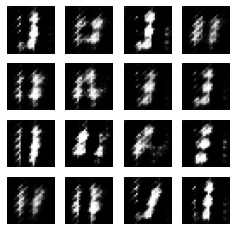

Time for epoch 3 is 35.38493084907532 sec


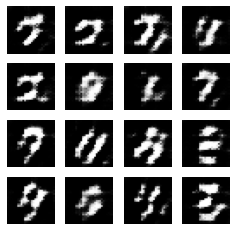

Time for epoch 4 is 35.22964358329773 sec


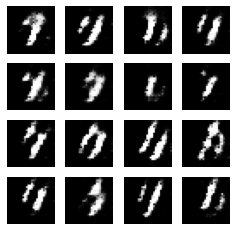

Time for epoch 5 is 35.28474521636963 sec


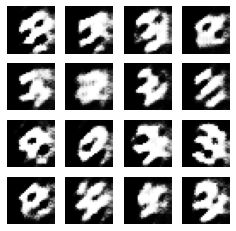

Time for epoch 6 is 34.90851640701294 sec


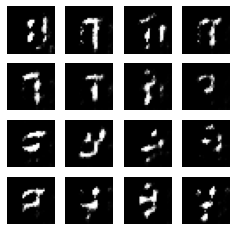

Time for epoch 7 is 35.565160512924194 sec


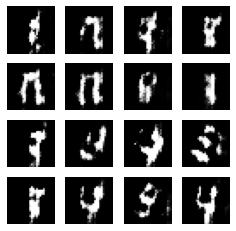

Time for epoch 8 is 34.81442356109619 sec


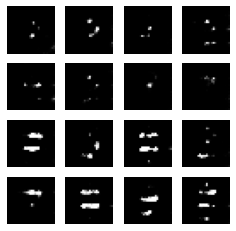

Time for epoch 9 is 34.959686279296875 sec


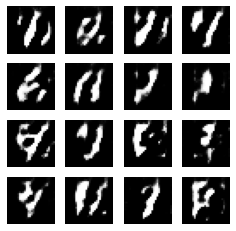

Time for epoch 10 is 35.45651364326477 sec


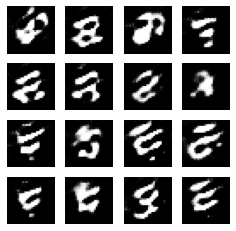

Time for epoch 11 is 35.05964994430542 sec


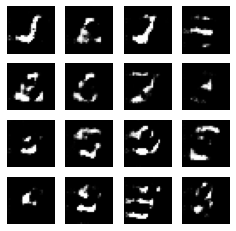

Time for epoch 12 is 35.22075009346008 sec


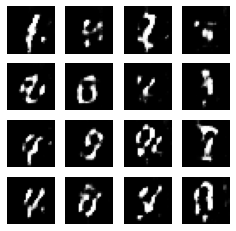

Time for epoch 13 is 35.262040853500366 sec


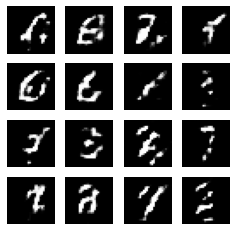

Time for epoch 14 is 34.72129988670349 sec


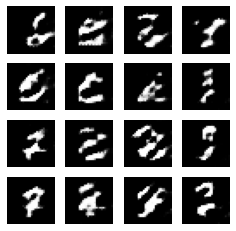

Time for epoch 15 is 35.389076471328735 sec


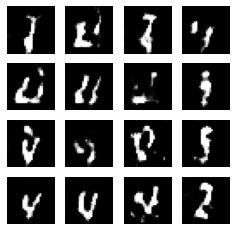

Time for epoch 16 is 35.316553831100464 sec


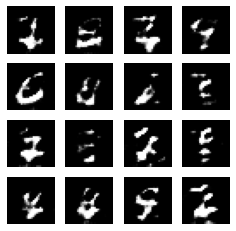

Time for epoch 17 is 35.075414419174194 sec


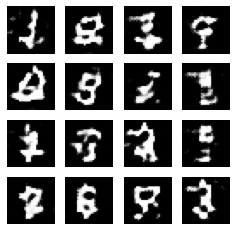

Time for epoch 18 is 35.013675928115845 sec


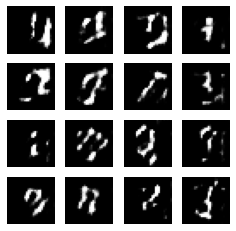

Time for epoch 19 is 35.022984981536865 sec


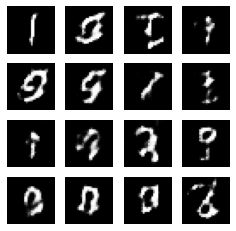

Time for epoch 20 is 35.048407793045044 sec


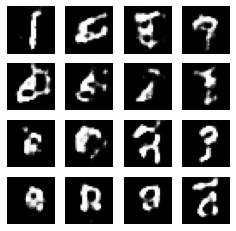

Time for epoch 21 is 35.21220374107361 sec


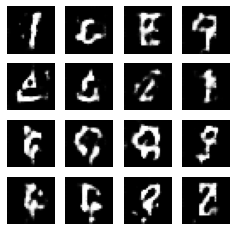

Time for epoch 22 is 35.120917081832886 sec


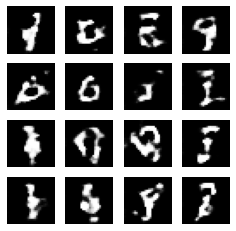

Time for epoch 23 is 35.055152893066406 sec


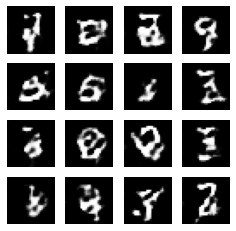

Time for epoch 24 is 34.90150856971741 sec


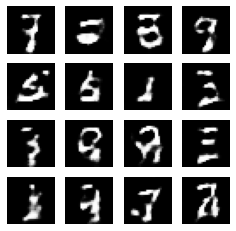

Time for epoch 25 is 34.86563754081726 sec


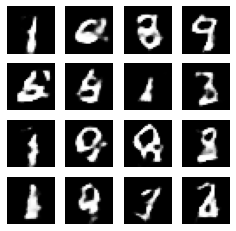

Time for epoch 26 is 34.956202030181885 sec


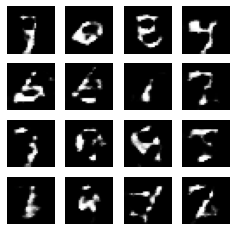

Time for epoch 27 is 44.805068016052246 sec


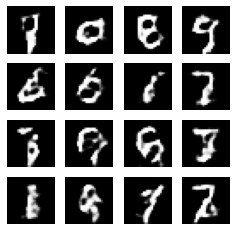

Time for epoch 28 is 45.525787353515625 sec


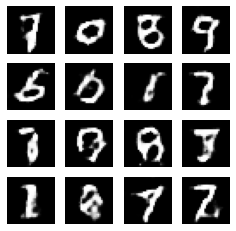

Time for epoch 29 is 46.46597337722778 sec


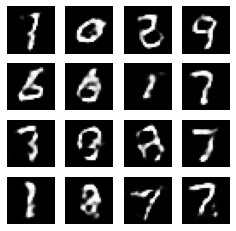

Time for epoch 30 is 46.77188229560852 sec


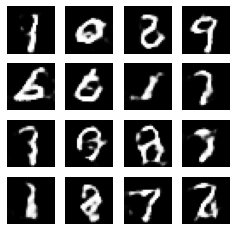

Time for epoch 31 is 46.063754081726074 sec


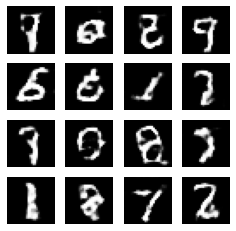

Time for epoch 32 is 46.330073595047 sec


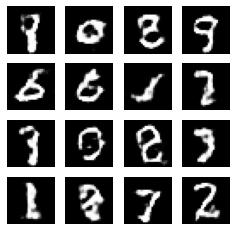

Time for epoch 33 is 46.412256717681885 sec


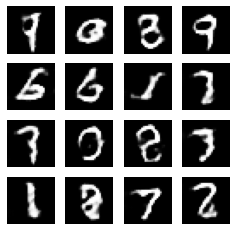

Time for epoch 34 is 45.73745274543762 sec


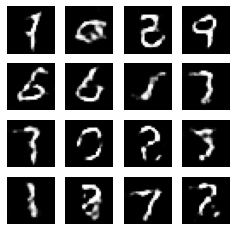

Time for epoch 35 is 46.5089168548584 sec


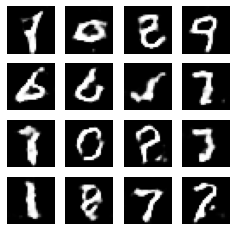

Time for epoch 36 is 46.61549758911133 sec


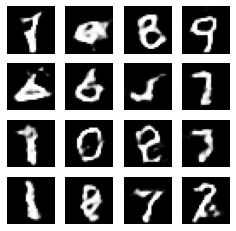

Time for epoch 37 is 35.37776589393616 sec


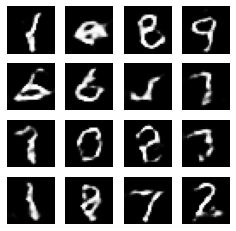

Time for epoch 38 is 34.801957845687866 sec


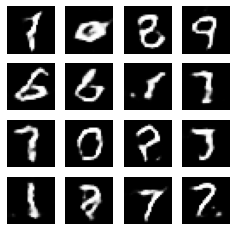

Time for epoch 39 is 34.777971506118774 sec


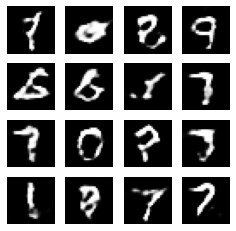

Time for epoch 40 is 34.79820156097412 sec


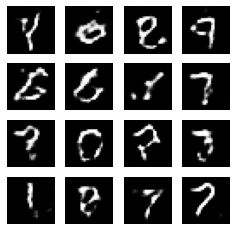

Time for epoch 41 is 34.71855139732361 sec


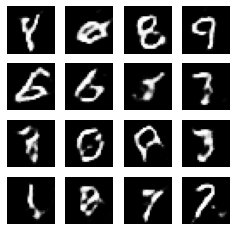

Time for epoch 42 is 34.96066379547119 sec


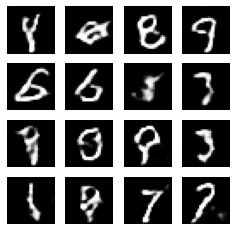

Time for epoch 43 is 45.217841148376465 sec


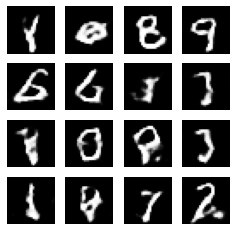

Time for epoch 44 is 46.30653977394104 sec


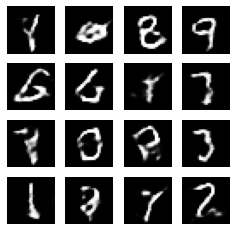

Time for epoch 45 is 47.24787139892578 sec


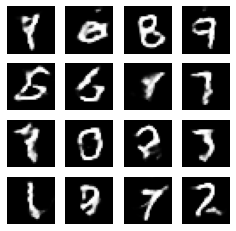

Time for epoch 46 is 46.12988543510437 sec


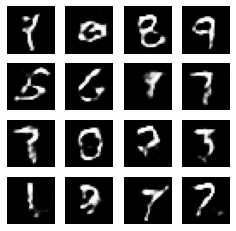

Time for epoch 47 is 46.72278594970703 sec


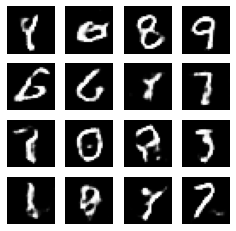

Time for epoch 48 is 45.894806146621704 sec


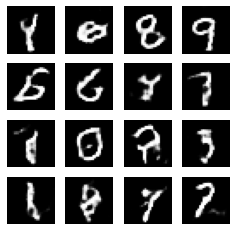

Time for epoch 49 is 45.81807994842529 sec


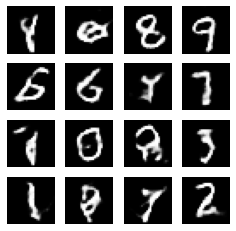

Time for epoch 50 is 45.442156076431274 sec


In [1]:
# MINST GAN Example
# based on https://www.tensorflow.org/tutorials/generative/dcgan

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import time

BUFFER_SIZE = 60000
BATCH_SIZE = 256

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

discriminator = models.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

generator = models.Sequential([
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)

    predictions = generator(seed, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))